In [1]:
!pip install kaggle

In [2]:
# Do set your runtime to GPU. You will need it
import torch
import math
from os import listdir
import numpy as np
from torch.autograd import Variable
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from os.path import join
from torchvision.models import vgg19
torch.autograd.set_detect_anomaly(True)

In [3]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


In [4]:
# Now, I will load in some code for the dataset and dataloaders.
# Link to this notebook will be in the description, so you can get it from there
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])


class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [5]:
train_set = TrainDatasetFromFolder("/kaggle/input/training-data-zip/DIV2K_train_HR", crop_size=CROP_SIZE,
                                   upscale_factor=UPSCALE_FACTOR)
trainloader = DataLoader(train_set, batch_size=64, num_workers=4, shuffle=True)

In [6]:
from torch import nn, optim

In [7]:
# Now we will start implementing the model. We will start in this vid, and co,plee
# in the next video
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        return x + residual

# We just implemented a pretty standard residual block here

In [8]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2,
                          kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

In [9]:
class Generator(nn.Module):
    def __init__(self, scale_factor, vgg):
        super(Generator, self).__init__()
        self.vgg = vgg
        upsample_block_num = int(math.log(scale_factor, 2))

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )

        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)
        return (torch.tanh(block8) + 1) / 2

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size()[0]
        return torch.sigmoid(self.net(x).view(batch_size))


In [11]:
class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]

        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])

        h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
        w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]


In [12]:
class GeneratorLoss(nn.Module):
    def __init__(self, vgg):
        super(GeneratorLoss, self).__init__()
        self.vgg = vgg
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        adversarial_loss = torch.mean(1 - out_labels)
        perception_loss = self.mse_loss(self.vgg(out_images), self.vgg(target_images))
        image_loss = self.mse_loss(out_images, target_images)
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


In [13]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Standard device selectoin
device

device(type='cuda')

In [14]:
import torch
import torchvision.models as models

# Check available weights for VGG19
print("Available VGG19 weights:")
print("  - ImageNet:", models.vgg19(pretrained=True))

# Load VGG19 with ImageNet weights
vgg = models.vgg19(pretrained=True).features.to(device).eval()


Available VGG19 weights:


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 162MB/s]  


  - ImageNet: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), strid

In [15]:
netG = Generator(UPSCALE_FACTOR, vgg).to(device)
netD = Discriminator().to(device)
generator_criterion = GeneratorLoss(vgg).to(device)

In [16]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)


In [18]:
from tqdm import tqdm
import os

# Initialize results dictionary
results = {
    "d_loss": [],
    "g_loss": [],
    "d_score": [],
    "g_score": []
}

N_EPOCHS = 1000  # First 100 epochs

for epoch in range(1, N_EPOCHS + 1):
    train_bar = tqdm(trainloader)
    running_results = {'batch_sizes': 0, 'd_loss': 0,
                       "g_loss": 0, "d_score": 0, "g_score": 0}

    netG.train()
    netD.train()

    for data, target in train_bar:
        g_update_first = True
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        real_img = Variable(target)
        real_img = real_img.to(device)
        z = Variable(data)
        z = z.to(device)

        ## Update Discriminator ##
        fake_img = netG(z)
        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph=True)
        optimizerD.step()

        ## Now update Generator
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        netG.zero_grad()
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()

        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        optimizerG.step()

        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += real_out.item() * batch_size

        ## Updating the progress bar
        train_bar.set_description(desc="[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f" % (
            epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']
        ))

    # Calculate average loss for the epoch
    avg_d_loss = running_results['d_loss'] / running_results['batch_sizes']
    avg_g_loss = running_results['g_loss'] / running_results['batch_sizes']

    # Save checkpoint every 10 epochs
    if epoch % 500 == 0 or epoch == N_EPOCHS:
        torch.save({
            'epoch': epoch,
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            'avg_d_loss': avg_d_loss,
            'avg_g_loss': avg_g_loss
        }, f'checkpoint_{epoch}.pth')

    netG.eval()  # Set back to evaluation mode after training


[1/1000] Loss_D: 0.8389 Loss_G: 0.0411 D(x): 0.5835 D(G(z)): 0.5835: 100%|██████████| 13/13 [00:41<00:00,  3.17s/it]
[2/1000] Loss_D: 0.5522 Loss_G: 0.0163 D(x): 0.7170 D(G(z)): 0.7170: 100%|██████████| 13/13 [00:37<00:00,  2.85s/it]
[3/1000] Loss_D: 0.3556 Loss_G: 0.0134 D(x): 0.8259 D(G(z)): 0.8259: 100%|██████████| 13/13 [00:37<00:00,  2.88s/it]
[4/1000] Loss_D: 0.1516 Loss_G: 0.0114 D(x): 0.9206 D(G(z)): 0.9206: 100%|██████████| 13/13 [00:37<00:00,  2.90s/it]
[5/1000] Loss_D: 0.4777 Loss_G: 0.0112 D(x): 0.8435 D(G(z)): 0.8435: 100%|██████████| 13/13 [00:39<00:00,  3.03s/it]
[6/1000] Loss_D: 0.8899 Loss_G: 0.0098 D(x): 0.7522 D(G(z)): 0.7522: 100%|██████████| 13/13 [00:37<00:00,  2.86s/it]
[7/1000] Loss_D: 0.4958 Loss_G: 0.0110 D(x): 0.7304 D(G(z)): 0.7304: 100%|██████████| 13/13 [00:37<00:00,  2.90s/it]
[8/1000] Loss_D: 0.2351 Loss_G: 0.0097 D(x): 0.8806 D(G(z)): 0.8806: 100%|██████████| 13/13 [00:37<00:00,  2.90s/it]
[9/1000] Loss_D: 0.0619 Loss_G: 0.0095 D(x): 0.9686 D(G(z)): 0.9

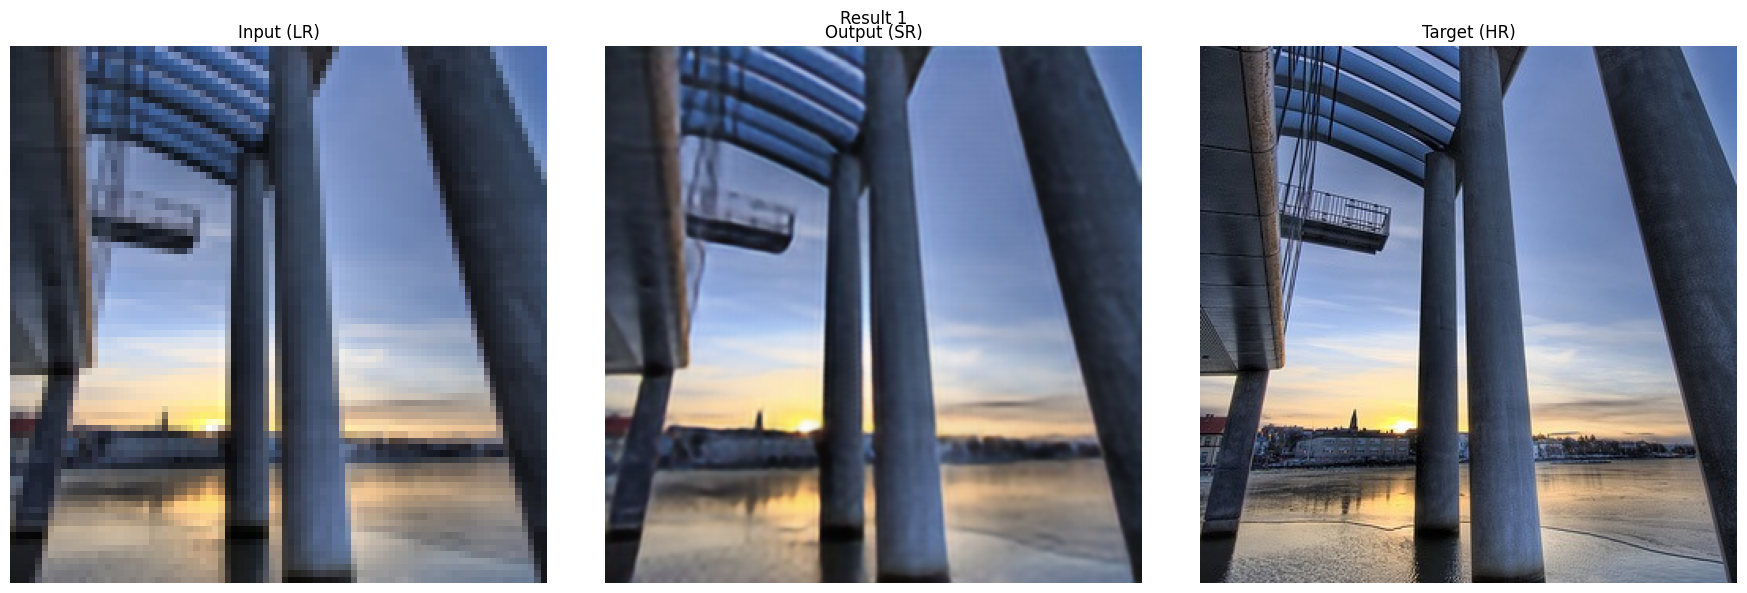

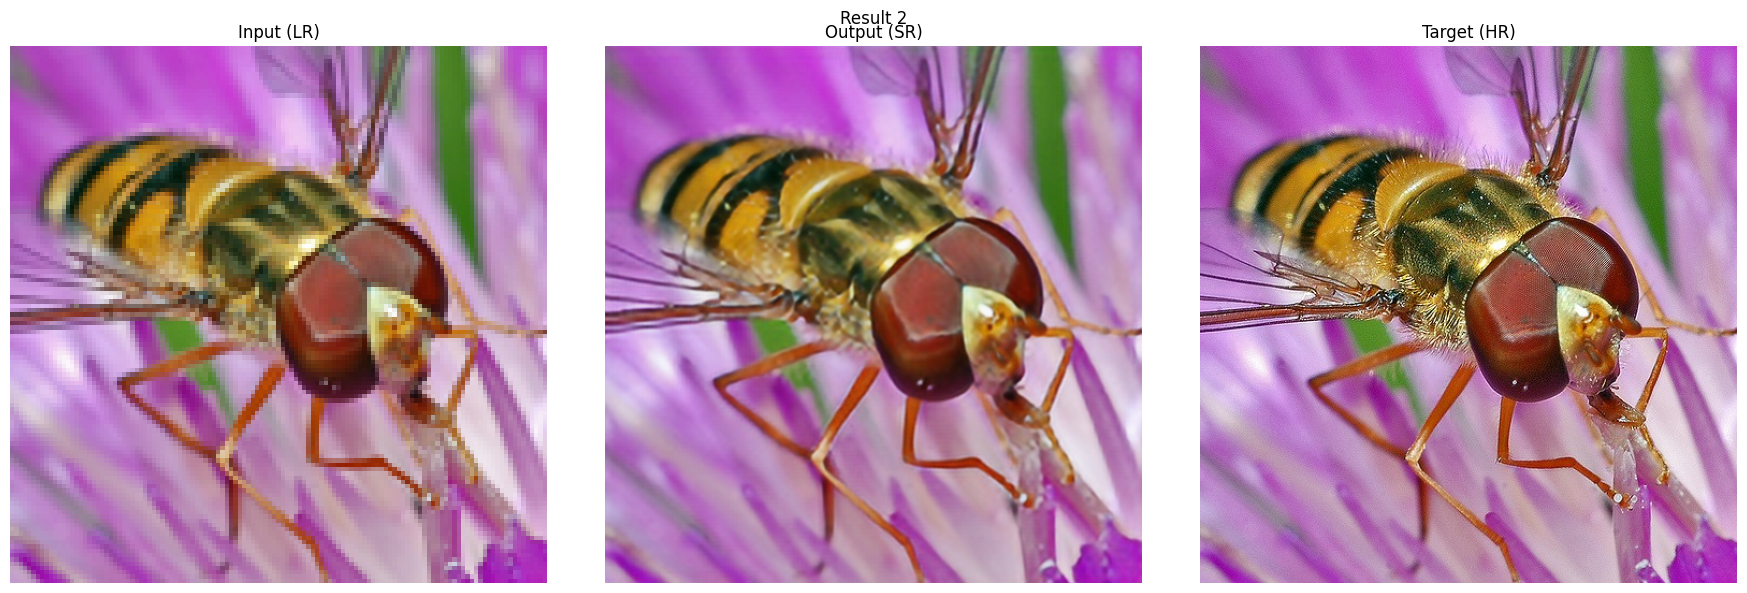

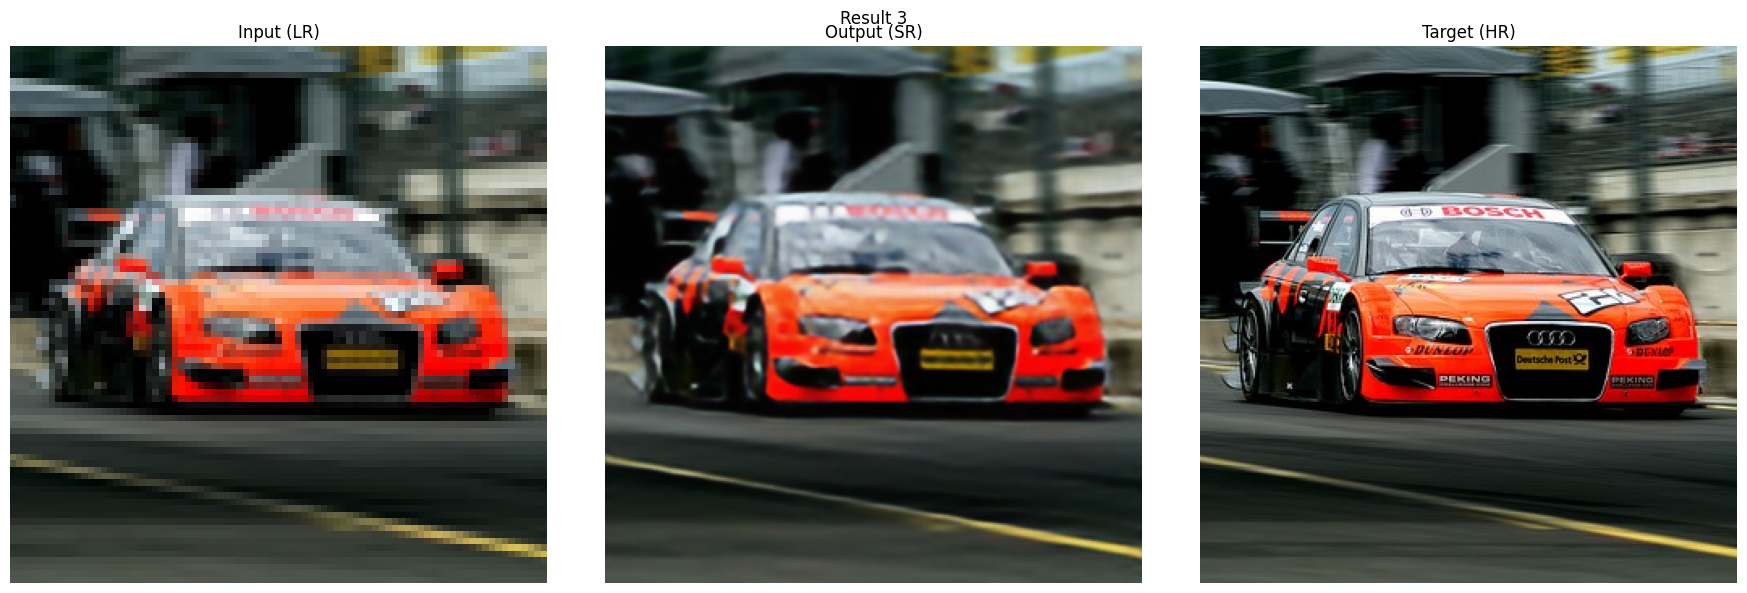

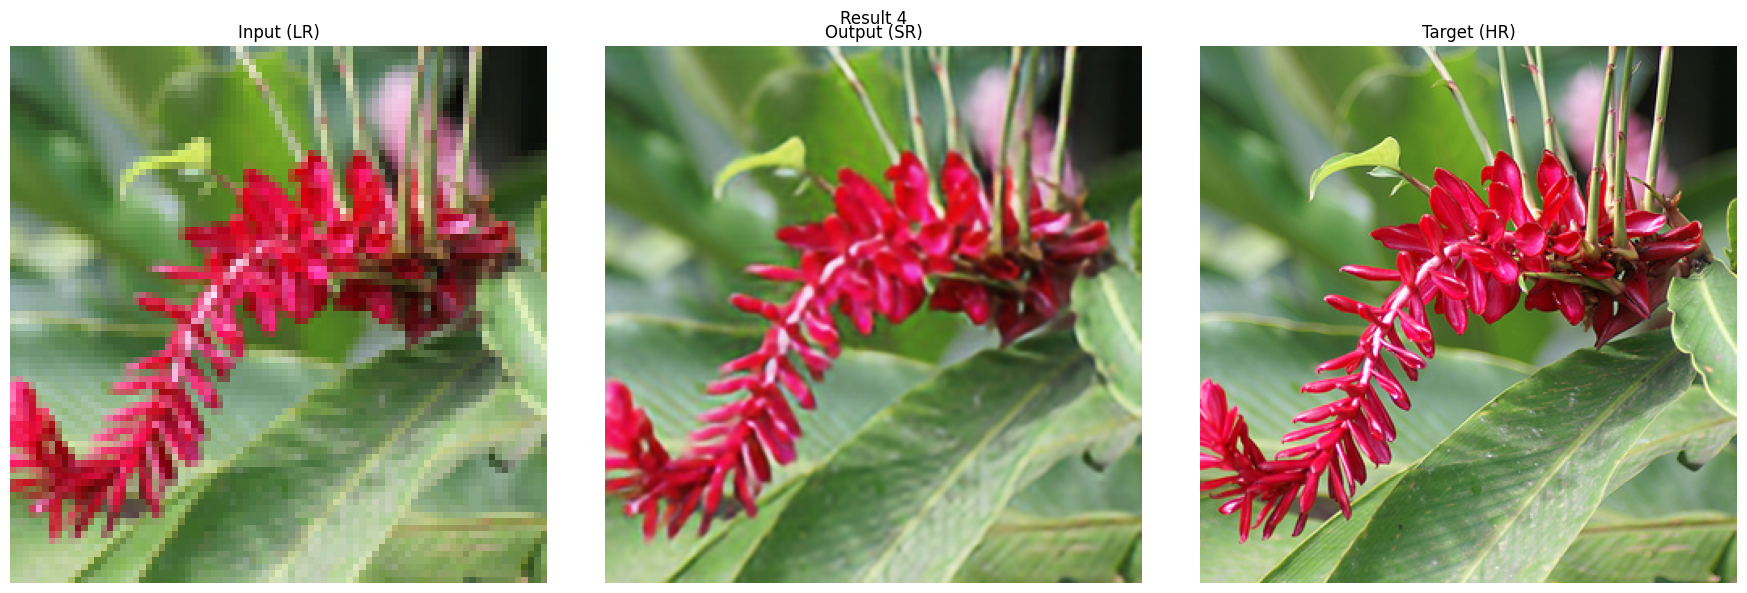

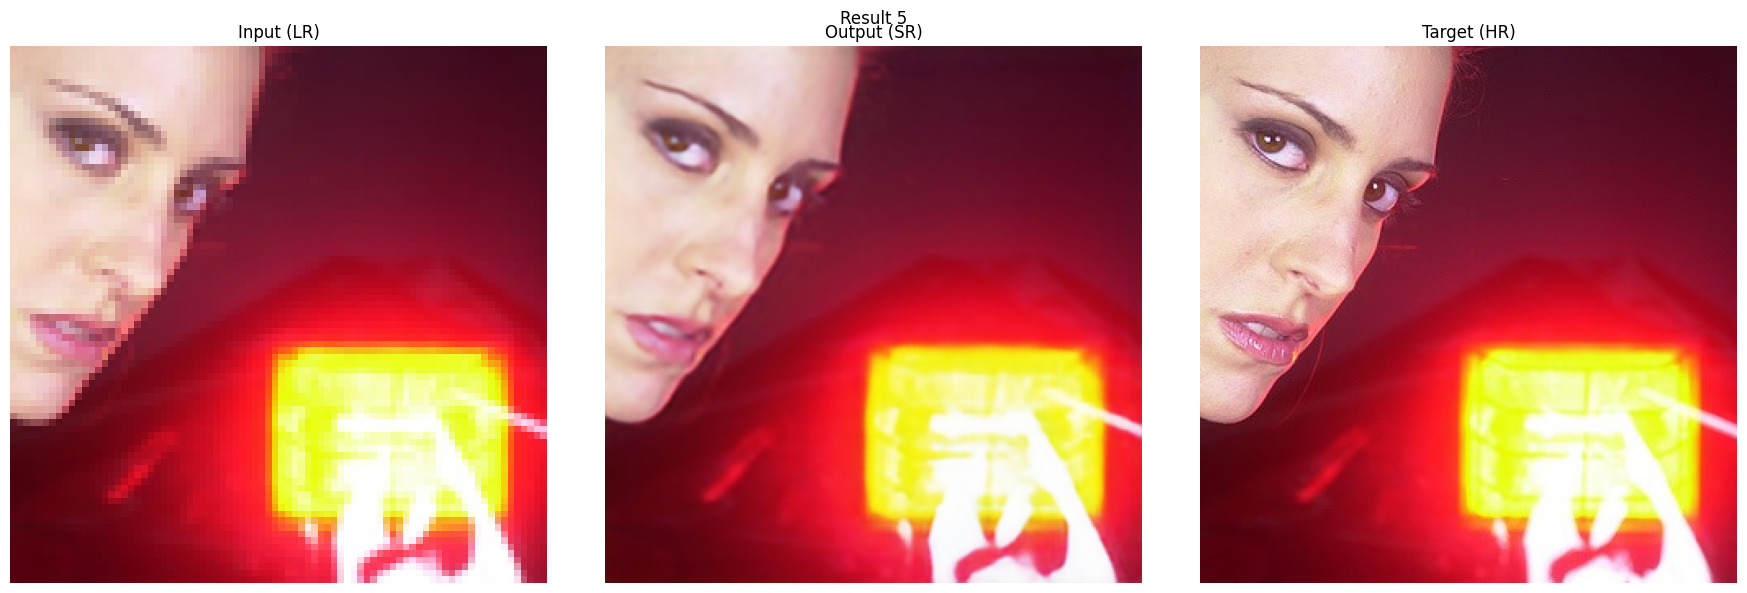

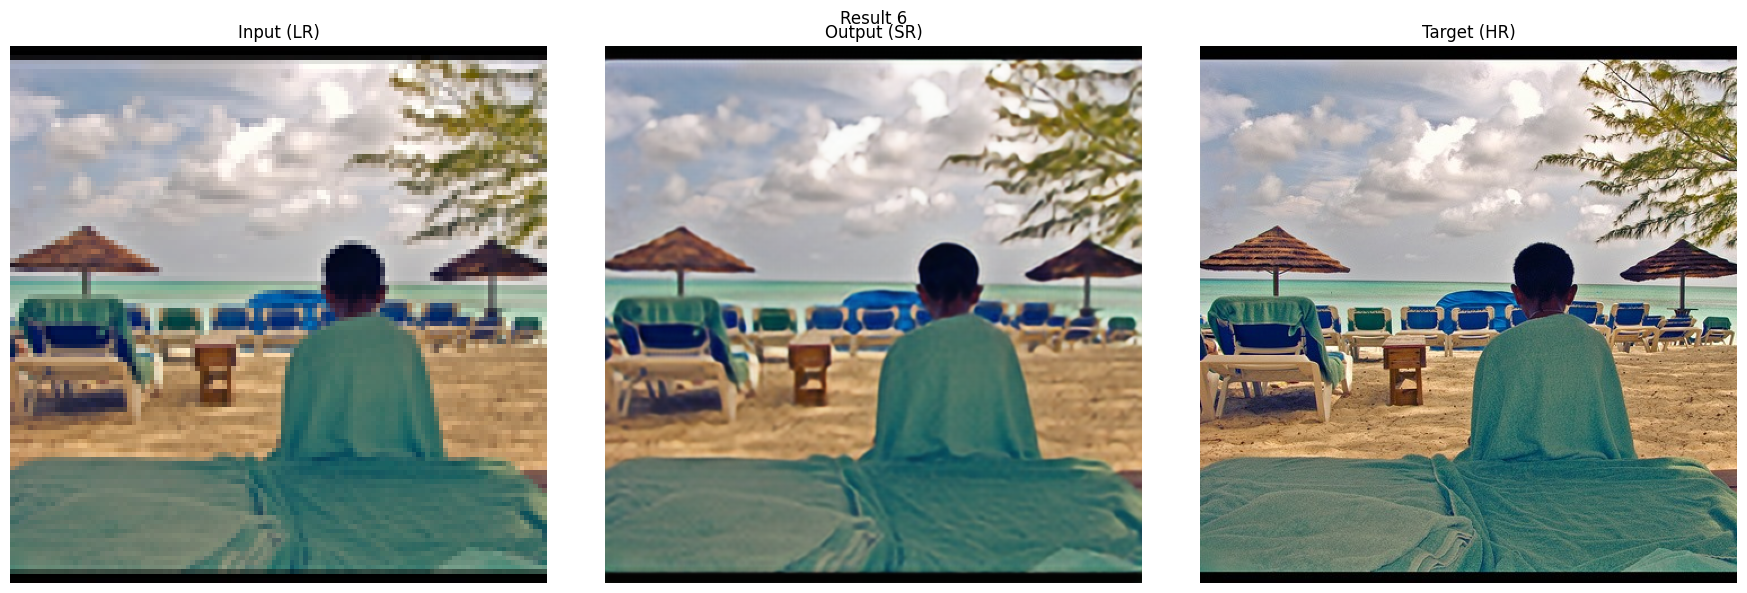

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, CenterCrop, ToTensor
from PIL import Image
from os import listdir
from os.path import join
import matplotlib.pyplot as plt

# Define a function to check if a file is an image file
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'])

# Define the TestDatasetFromFolder class
class TestDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, upscale_factor):
        super(TestDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        self.upscale_factor = upscale_factor

    def __getitem__(self, index):
        hr_image = Image.open(self.image_filenames[index]).convert('RGB')  # Ensure RGB format
        w, h = hr_image.size
        crop_size = calculate_valid_crop_size(min(w, h), self.upscale_factor)
        lr_scale = Resize(crop_size // self.upscale_factor, interpolation=Image.BICUBIC)
        hr_scale = Resize(crop_size, interpolation=Image.BICUBIC)
        hr_image = CenterCrop(crop_size)(hr_image)
        lr_image = lr_scale(hr_image)
        hr_restore_img = hr_scale(lr_image)
        return ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

    def __len__(self):
        return len(self.image_filenames)

# Define your model (assuming you've already defined and loaded 'netG')
netG.eval()  # Set model to evaluation mode

# Directory containing test images
test_dataset_dir = "/kaggle/input/test-data"  # Update with your test image directory
UPSCALE_FACTOR = 4  # Define your upscale factor here

# Create the dataset and data loader
test_set = TestDatasetFromFolder(test_dataset_dir, UPSCALE_FACTOR)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

# Evaluate the model on test images and store the results
test_results = []
with torch.no_grad():
    for data in test_loader:
        input, hr_restore, target = data
        input = input.to(device)
        hr_restore = hr_restore.to(device)
        target = target.to(device)
        prediction = netG(input)
        test_results.append((input, prediction, hr_restore, target))

# Define a function to display the results for all images
def display_results(results):
    for i, (input, output, hr_restore, target) in enumerate(results):
        display_result(input, output, target, f"Result {i+1}")

# Define a function to display a single result
def display_result(input, output, target, title):
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(input.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    plt.title('Input (LR)')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(output.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    plt.title('Output (SR)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(target.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    plt.title('Target (HR)')
    plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display results for all images
display_results(test_results)
